# 1 - Importing Dependecies 

In [402]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
from matplotlib import pyplot as plt
import matplotlib as mpl
import tensorflow as tf
import pandas as pd
import numpy as np 
import random
import cv2
import os



import time

# 1.1 - Data Pipeline 

In [438]:
os.listdir()

## Data Directory Path
print('#1 - Initialzing DataFrame...\n')
imageID_Path = os.listdir('data/main')

## Creating data frame based on directory contents 
imagePath_df = pd.DataFrame({'ID':[n.split('.')[0] for n in imageID_Path],
                                'Path':['data/main/' + n for n in imageID_Path]})

## Extracting features of images from the CSV file
csv_dataPath = os.path.join('data/main','data.csv')
imageFeatures_df = pd.read_csv(csv_dataPath, sep=',')

## COnvoerting all values to integer values
imagePath_df["ID"]= pd.to_numeric(imagePath_df["ID"],errors='coerce')



## Error handling for none JPEG Images

for i,row in imagePath_df.iterrows():
    picture_Path = row['Path']
    # print(picture_Path)
    extCheck = len(picture_Path)
    path = picture_Path[extCheck-4:]
    if (path != 'JPEG'):
        imagePath_df.drop(i, inplace=True)


print( "Numbers of Images succefully imported:",len(imagePath_df))




#1 - Initialzing DataFrame...

Numbers of Images succefully imported: 4041


In [439]:
merged_df = pd.merge(left=imagePath_df, right=imageFeatures_df, on='ID', how='inner', )

print('Merging Dataframes...')

Merging Dataframes...


In [423]:
len(merged_df)

3994

# 2 - Cleaning Data

In [440]:
## Validating the data
print('Cleaning Data...')


merged_df['Hammer Price'] = pd.to_numeric(merged_df['Hammer Price'], errors='coerce')

merged_df = merged_df.replace(np.nan, 0)

# merged_df['Low Estimation Price'].replace(np.nan, 0)

means = []

for i, row in merged_df.iterrows():

    if(row['Low Estimation Price'] == 0 and row['High Estimation Price'] == 0):
        mean = row['Hammer Price'] / 2
    
    elif (row['Low Estimation Price'] == 0):
        mean = (row['High Estimation Price']) / 2
    else:
        mean = (row['Low Estimation Price'] + row['High Estimation Price']) / 2

    means.append(np.log(mean)**-1)
    
    if(row['Hammer Price'] == 0.0): 
        merged_df.loc[i, 'Hammer Price'] = mean


# 
merged_df['Mean Estimation'] = pd.Series(means)


Cleaning Data...


<AxesSubplot:>

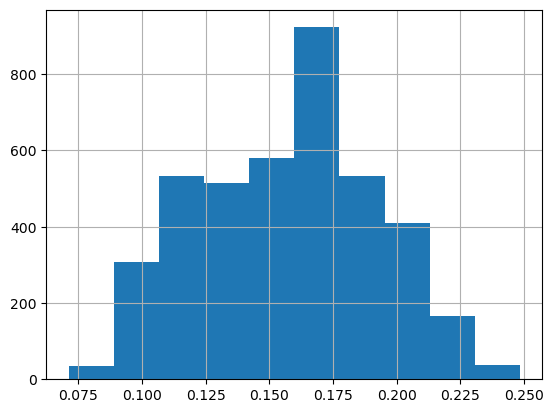

In [441]:
merged_df['Mean Estimation'].hist()

In [408]:
# print('Normalizing Data...')
# CntRem = 0
# for i in range(len(merged_df)): 
#     if(merged_df.at[i,'Mean Estimation'] > 1000):
#         CntRem +=1 
#         os.remove(merged_df.at[i,'Path'])
#         # merged_df.drop(merged_df.at[merged_df.index[i]], axis=0)

#         # print("Image", merged_df.at[i,'ID']," to be removed")

# print("Total number of files removed", CntRem)

In [442]:
merged_df.drop(['Path', 'ID', 'Low Estimation Price','High Estimation Price', 'Hammer Price'],inplace=True, axis=1)


In [427]:
merged_df.head()

,Artist,Size,Medium,Mean Estimation
0,Ole Kielberg,42cm-59cm(16.54in-23.23in),Oil on canvas,210.0
1,Sam Nhlengethwa,30cm-33cm(11.81in-12.99in),Lithograph on paper,270.0
2,I. H. Brandt,12cm-17.5cm(4.72in-6.89in),Oil on mahogany,245.0
3,Sam Francis,63.2cm-90.5cm(24.88in-35.63in),Lithograph Three lithographs printed in colors,7000.0
4,Svend Sinding Christensen,63.5cm-77cm(25in-30.31in),Oil on canvas,140.0


In [443]:
from sklearn.preprocessing import LabelEncoder

# inputs_df.unique()


le = LabelEncoder()

merged_df['Artist'] = le.fit_transform(merged_df['Artist'])
merged_df['Medium'] = le.fit_transform(merged_df['Medium'])
merged_df['Size'] = le.fit_transform(merged_df['Size'])



In [444]:
X = merged_df.iloc[:3500,0:3].values
y = merged_df.iloc[:3500,3].values
X_test = merged_df.iloc[3500:,0:3].values
y_test = merged_df.iloc[3500:,3].values

In [362]:
X_test.shape
# y[0]

(432, 3)

In [445]:
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
regressor.fit(X,y)

RandomForestRegressor(random_state=0)

In [307]:
y_test[1]

7.033506484287697

In [446]:
results = []
results_Actual = []
for i in range(len(X_test)): 
    results_Actual.append(y_test[i])
    results.append(regressor.predict([X_test[i]]))

results = np.array(results)

In [447]:
results  =results.flatten()

In [448]:
dfData = list(zip(results_Actual, results))
results_df = pd.DataFrame(dfData, columns=['Actual Mean Estimation', 'Predicted Estimation'])

In [449]:
results_df.head()

,Actual Mean Estimation,Predicted Estimation
0,0.152647,0.164807
1,0.128142,0.177640
2,0.133916,0.158549
3,0.177469,0.175350
4,0.202362,0.176062


array([[<AxesSubplot:title={'center':'Actual Mean Estimation'}>,
        <AxesSubplot:title={'center':'Predicted Estimation'}>]],
      dtype=object)

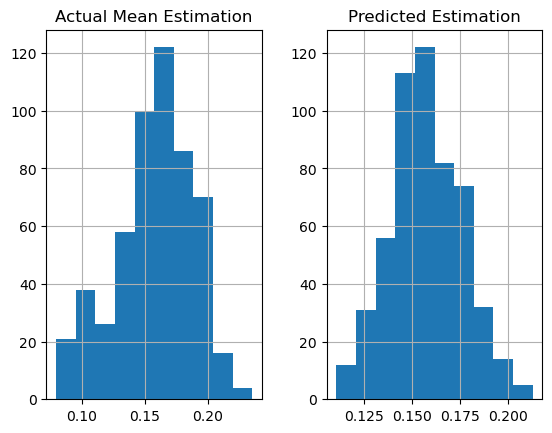

In [450]:
results_df.hist()

In [453]:
results_df = results_df ** -10

array([[<AxesSubplot:title={'center':'Actual Mean Estimation'}>,
        <AxesSubplot:title={'center':'Predicted Estimation'}>]],
      dtype=object)

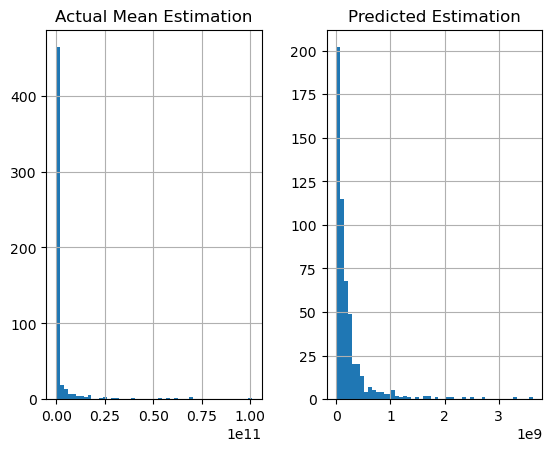

In [460]:
results_df.hist(bins=50)

In [452]:
print (regressor.score(X, y))
print(regressor.score(X_test, y_test))

0.9090965855997298
0.23973317871260047
